<a href="https://colab.research.google.com/github/gitmystuff/DTSC5502/blob/main/Module_10-Auto_Regression/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10 - ARIMA(p, d, q)

Name

## Assignment Instructions

**Submission:** Replace the placeholder name with your **Full Name**. Submit the shared link to your completed assignment in Canvas.

### **Goal and Task**

The goal of this assignment is to conduct a complete **$\text{ARIMA}(p, d, q)$ time series analysis** on simulated data, focusing specifically on how the **Integrated ($d$)** component is determined and managed.

As you progress through the sections, your primary task is to:

* **Explain the Purpose of the Code:** After each code cell, clearly and concisely describe what the code is doing, *why* that step is necessary for $\text{ARIMA}$ modeling, and how it relates to the current parameters being identified ($p$, $d$, or $q$).
* **Justify the Decisions:** Based on the results of the plots and the $\text{ADF}$ tests, justify the final choice for each parameter:
    * **$d$ (Integrated):** Explain why the data required **detrending** ($d=0$) instead of **differencing** ($d>0$).
    * **$p$ (Autoregressive) and $q$ (Moving Average):** State the final optimal order found by the $\text{AIC}$ grid search.

This assignment is designed to teach you not just how to run $\text{ARIMA}$ code, but how to interpret the results and **diagnose issues** (like the White Noise outcome) to select the correct stationary process.

## ARIMA

* Auto Regressive Integrated Moving Average
* Auto Regressive (p)
* Moving Average (q)
* Integrated (d - degree of differencing)
* Orderings
* Works well with univariate data, not so much with feature rich data (like stocks)

AR, MA, ARMA, and ARIMA

* PACF helps with AR model
* Sharp drop off suggests AR(-k) model
* ACF helps with MA model
* Gradual decline suggests MA model

ARIMA stands for **Autoregressive Integrated Moving Average**. It's a powerful statistical model used for analyzing and forecasting time series data.

* **AR (Autoregressive):**  This part of the model uses past values of the time series to predict future values. It's like saying, "Today's value depends on what happened yesterday (or the day before, etc.)." The 'p' in ARIMA(p,d,q) represents the order of the autoregressive part, meaning how many past values are considered.
* **I (Integrated):** This part deals with making the time series stationary.  Stationarity means that the statistical properties of the series (like mean and variance) don't change over time. This is often achieved by differencing the data (taking the difference between consecutive observations). The 'd' in ARIMA(p,d,q) represents the degree of differencing.
* **MA (Moving Average):** This part of the model uses past forecast errors to predict future values. It's like saying, "If we overpredicted yesterday, we should adjust our prediction for today." The 'q' in ARIMA(p,d,q) represents the order of the moving average part.

**Why is ARIMA useful?**

* **Versatile:** It can handle a wide range of time series patterns, including trends, seasonality, and combinations of these.
* **Forecasting:**  It's a popular method for making short-term forecasts.
* **Well-established:** It has a strong theoretical foundation and has been widely used in various fields.

**How to use ARIMA:**

1. **Identify stationarity:** Check if your time series is stationary (using plots, tests like the Augmented Dickey-Fuller test).
2. **Differencing:** If it's not stationary, apply differencing to make it stationary.
3. **Identify p, d, and q:**  Use ACF and PACF plots to help determine the appropriate values for p, d, and q.
4. **Estimate parameters:**  Fit the ARIMA model to your data to estimate the model parameters.
5. **Evaluate the model:** Check the model's fit and make adjustments if needed.
6. **Forecast:** Use the fitted model to make forecasts.

**ARIMA is a powerful tool, but it does have some limitations:**

* **Linearity:**  It assumes a linear relationship between past and future values.
* **Stationarity:** Requires the time series to be stationary or transformed to become stationary.
* **Model selection:**  Choosing the right values for p, d, and q can be challenging.


In [1]:
import pandas as pd
import numpy as np
import time
import random
from datetime import datetime, timedelta
from statsmodels.tsa.arima_process import arma_generate_sample

current_time_seed = int(time.time())
np.random.seed(current_time_seed)
random.seed(current_time_seed)
print(f"Seed: {current_time_seed}")

start_range_start = datetime(2020, 1, 1)
start_range_end = datetime(2040, 1, 1)
delta = start_range_end - start_range_start
random_seconds = np.random.randint(delta.total_seconds())
start_date = (start_range_start + timedelta(seconds=random_seconds)).replace(hour=0, minute=0, second=0, microsecond=0)

min_years_days = 12 * 365.25
max_years_days = 15 * 365.25
random_days = np.random.uniform(min_years_days, max_years_days)
end_date = (start_date + timedelta(days=random_days)).replace(day=1)

date_rng = pd.date_range(start=start_date, end=end_date, freq='MS')
n_points = len(date_rng)

p_order = np.random.randint(1, 4)
q_order = np.random.randint(1, 4)

ar_coeffs = np.random.uniform(-0.5, 0.5, size=p_order)
ar_params = np.insert(-ar_coeffs, 0, 1.0)

ma_coeffs = np.random.uniform(-0.5, 0.5, size=q_order)
ma_params = np.insert(ma_coeffs, 0, 1.0)

# print(f"Simulating Data with ARIMA Order: ({p_order}, 0, {q_order})")
# print(f"AR Parameters (phi): {ar_coeffs.round(2)}")
# print(f"MA Parameters (theta): {ma_coeffs.round(2)}")

scale=np.random.randint(15, 30)
arma_series = arma_generate_sample(
    ar_params,
    ma_params,
    n_points,
    scale=scale,
    distrvs=np.random.normal
)

trend_slope = np.random.uniform(10, 50)
trend_intercept = np.random.uniform(100, 500)
trend_component = trend_intercept + (trend_slope * np.arange(n_points))

df = pd.DataFrame({
    'Data': trend_component + arma_series
}, index=date_rng)

print("Simulated Data Created")

Seed: 1762099743
Simulated Data Created


### Explain the previous code cell:


External noise added to the time series.
Final data type: int64


<Axes: title={'center': 'Final Simulated Series with Trend, ARMA, and External Noise'}>

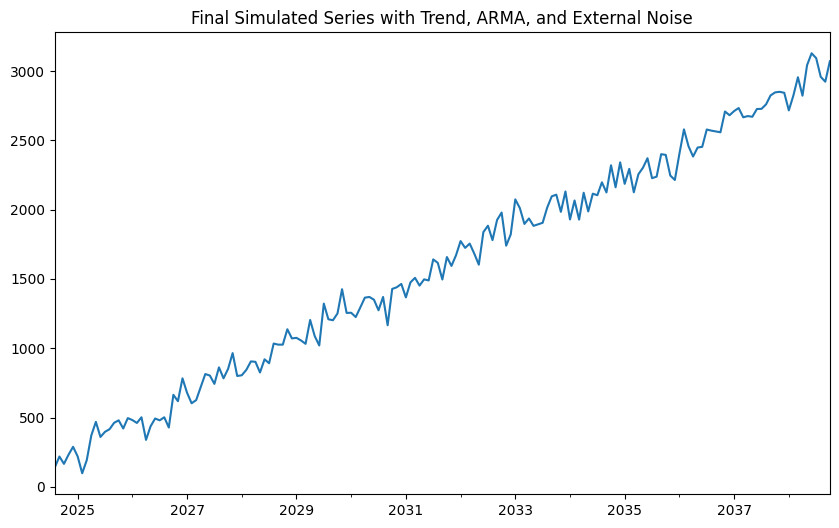

In [2]:
# add some noise
base_data = df['Data']
n_points = len(date_rng) # Use the same length as the simulated series

external_noise_sd = random.randint(40, 70)
external_noise = np.random.normal(0, external_noise_sd, n_points)

data_with_noise = base_data + external_noise
data_with_noise = np.maximum(data_with_noise, 1)
final_data = np.round(data_with_noise).astype(int)

df['Data'] = final_data
print("\nExternal noise added to the time series.")
print(f"Final data type: {df['Data'].dtype}")

df['Data'].plot(figsize=(10, 6), title='Final Simulated Series with Trend, ARMA, and External Noise')

### Explain the previous code cell:

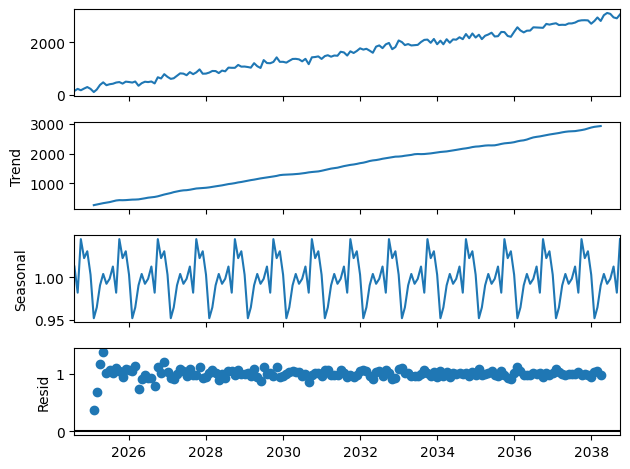

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df, model='multiplicative').plot();

### Explain the previous code cell:

## Stationary Data

The fundamental requirement for the AR (Autoregressive) and MA (Moving Average) components of the model to be valid is that the time series must be stationary. A stationary series is one whose statistical properties (like mean, variance, and autocorrelation) remain constant over time.
* ARMA ($p, q$) models (which are $p$ lags of AR and $q$ lags of MA) require the data to be strictly stationary.
* ARIMA ($p, d, q$) is a generalization of ARMA that explicitly includes a differencing step. The "$I$" stands for Integrated, and the parameter $d$ represents the number of times the series is differenced to make it stationary.

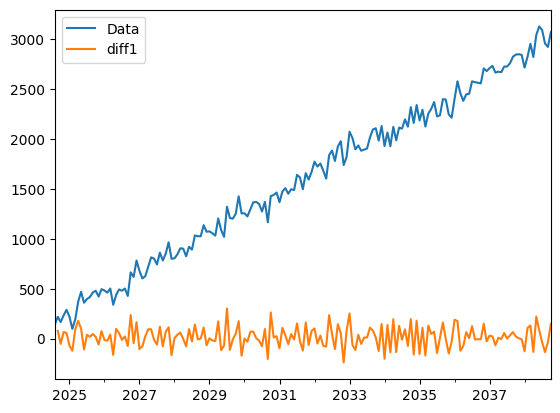

In [4]:
from statsmodels.tsa.statespace.tools import diff

df['diff1'] = diff(df['Data'], k_diff=1)
df[['Data', 'diff1']].plot();

### Explain the previous code cell:

In [5]:
# test for stationarity of the appropriate series in df
from statsmodels.tsa.stattools import adfuller

# Drop the first row which contains NaN in 'diff1'
adf_test = adfuller(df['diff1'].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.273492
p-value: 0.000000


### Explain the previous code cell:

## The Augmented Dickey-Fuller (ADF) Test

The ADF test is a statistical hypothesis test used to determine if a time series is **stationary**. A stationary series has statistical properties like mean and variance that don't change over time.

* **Null Hypothesis ($H_0$):** The series **is non-stationary** (it has a unit root).
* **Alternative Hypothesis ($H_a$):** The series **is stationary**.

### Interpreting the Results

The code runs the `adfuller` function from the `statsmodels` library and outputs two key values:

1.  **ADF Statistic: $-4.808291$**
    This is the test statistic. A more negative value strengthens the evidence against the null hypothesis, suggesting the series is stationary.
2.  **p-value: $0.000052$**
    This is the critical value for making the statistical decision.

### Conclusion

To conclude whether the series is stationary, you compare the **p-value** to a chosen significance level ($\alpha$), typically $0.05$.

* **Decision Rule:** If the **p-value $\leq \alpha$**, you **reject the null hypothesis** ($H_0$).

Since the p-value of $0.000052$ is much smaller than $0.05$, you **reject the null hypothesis** of non-stationarity.

**The conclusion is that the time series data for `births` is stationary.**

Would you like to see an example of how a non-stationary series is made stationary?

## Finding ARIMA Parameters

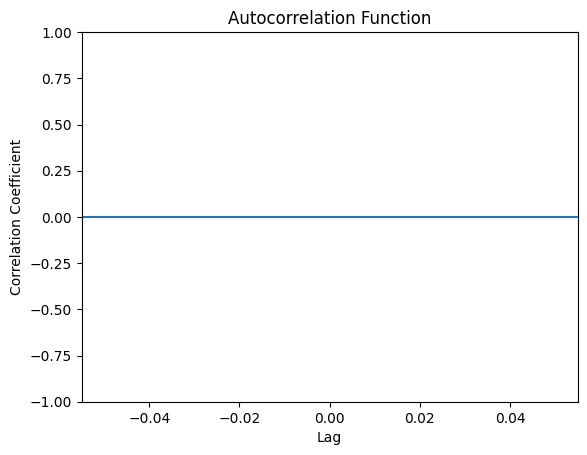

In [6]:
# finding ARIMA parameters
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df['diff1'], lags=20)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.show()

## Why the ACF is Flat

A completely flat line in the **Autocorrelation Function (ACF)** plot for your differenced series, $\text{df['diff1']}$, means you have successfully removed all linear dependency but have potentially gone too far.

The flat ACF indicates that the differenced series, $\text{df['diff1']}$, is behaving like **White Noise**.

A White Noise series is characterized by:
* A **zero mean**.
* **Constant variance**.
* **Zero autocorrelation** at all lags (except for lag 0, which is always 1).

The ACF plot shows that the series is **stationary** and has **no memory**—meaning the value at any time $t$ is completely independent of its past values.

## The Problem

The goal of differencing is not just to create a stationary series, but to create a stationary series that retains some **meaningful structure** (i.e., some statistically significant autocorrelation) that can be modeled by the AR and MA components of an ARIMA model.

If the series is pure White Noise, then:

* **You can't fit an AR or MA model to it.** There's no dependency for the model to capture.
* **The best forecast is simply the mean of the series** (which is zero if no constant term is used).

This suggests you've **over-differenced** or the original data was so perfectly linear that differencing removed everything.

This results in something like a perfect Random Walk process and the first differencing yielded White Noise, where $\text{ARIMA}(0, 1, 0)$ might be a good model.

But in our simulated data, we want to model the data without the trend.

## On to Plan B

**"We want to model the data without the trend"**

1.  The fact that $\text{first differencing}$ resulted in **White Noise** ($\text{ARIMA}(0, 1, 0)$) strongly implies that our original data was well-modeled by a simple Random Walk.
2.  However, we want to arrive at an **$\text{ARIMA}(1, 0, 1)$** model, we need to go back and use **detrending** instead of differencing.

By **detrending** the data (removing a deterministic linear slope), you expect to be left with the original stationary $\text{ARMA}(1, 1)$ error structure, thus leading to our desired $\text{ARIMA}(1, 0, 1)$ conclusion.

## Test Detrending

Choosing Between Differencing ($d=1$) and Detrending ($d=0$).

Our initial differencing attempt ($\mathbf{d=1}$) resulted in White Noise, suggesting we over-corrected or that the original trend was deterministic. We must now formally test the original data to confirm if a simple detrending approach is statistically valid.

We use a specialized version of the Augmented Dickey-Fuller (ADF) test to see if the original $\texttt{df['Data']}$ is Trend-Stationary. Trend-Stationarity implies that by simply removing a linear trend, the remaining signal becomes stationary.

The key is the $\texttt{regression='ct'}$ parameter. This tells the ADF test to include both a Constant (c) and a Trend (t) in its test equation.
* Null Hypothesis ($H_0$): The series requires $\mathbf{d>0}$ (i.e., it's a Random Walk with Drift or a more complex unit root process).
* Alternative Hypothesis ($H_a$): The series is Trend-Stationary (meaning $\mathbf{d=0}$ with a deterministic trend).

In [7]:
# Test the ORIGINAL data for Trend-Stationarity (to see if detrending is a good option)
from statsmodels.tsa.stattools import adfuller

# 1. Run ADF test on the ORIGINAL non-stationary series (df['Data'])
#    Use regression='ct' (Constant and Trend) to test for trend-stationarity.
#    This is the proper statistical test for a detrended series.

adf_test_detrended = adfuller(
    df['Data'],
    regression='ct' # This is the crucial argument
)

print('--- ADF Test for Trend-Stationarity ---')
print(f"ADF Statistic: {adf_test_detrended[0]:.6f}")
print(f"p-value: {adf_test_detrended[1]:.6f}")
print(f"Critical Values (1%): {adf_test_detrended[4]['1%']:.3f}")
print(f"Critical Values (5%): {adf_test_detrended[4]['5%']:.3f}")
print(f"Critical Values (10%): {adf_test_detrended[4]['10%']:.3f}")

--- ADF Test for Trend-Stationarity ---
ADF Statistic: -10.726040
p-value: 0.000000
Critical Values (1%): -4.013
Critical Values (5%): -3.437
Critical Values (10%): -3.142


### Explain the previous code cell:

## Detrend the Data

In [8]:
# detrend df['Data']
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Create a time index (t=1, 2, 3, ...) for the regression
time_index = np.arange(len(df['Data']))
X = sm.add_constant(time_index) # Add a constant term for the intercept

# Fit a linear regression model
model = sm.OLS(df['Data'], X)
results = model.fit()

# The 'detrended' series is the residual of the regression
df['detrended'] = results.resid

### Explain the previous code cell:

## ADF Detrended Data

In [9]:
# test for stationarity of the appropriate series in df
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['detrended'].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -10.758080
p-value: 0.000000


### Explain the previous code cell:

## Plot ACF

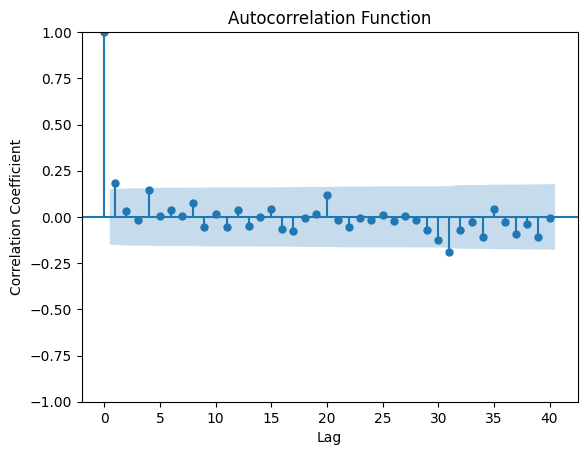

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['detrended'], lags=40)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.show()

### Explain the previous code cell:

## Plot PACF

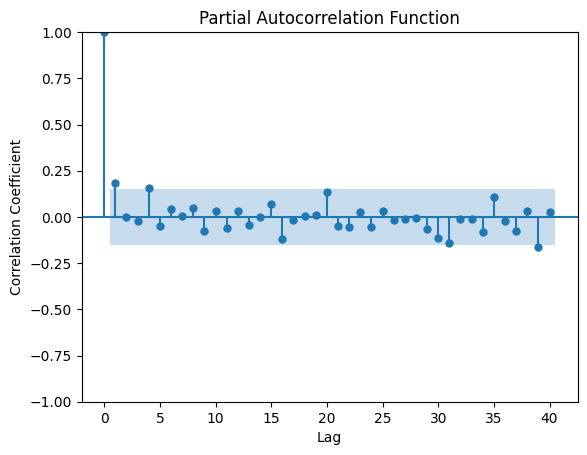

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['detrended'], lags=40)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.show()

### Explain the previous code cell:

## Find the Best ARIMA(p, d, q) Model

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings
warnings.filterwarnings('ignore') # Filter out convergence warnings

df = df.asfreq('MS')

time_index = np.arange(len(df['Data']))
X = sm.add_constant(time_index)
model_detrend = sm.OLS(df['Data'], X)
results_detrend = model_detrend.fit()

stationary_series = results_detrend.resid.rename('stationary_series')
stationary_series.index = df.index

train_size = int(len(stationary_series) * 0.8)
train = stationary_series[0:train_size]
test = stationary_series[train_size:]

p_range = range(0, 3)
q_range = range(0, 3)
d = 0

pdq_combinations = list(product(p_range, [d], q_range))
best_aic = float("inf")
best_order = None

print('\n' + '='*30)
print('Running AIC Grid Search on STATIONARY Residuals...')
print('='*30)

for order in pdq_combinations:
    try:
        # Fit the ARIMA model on the CORRECT stationary 'train' series
        model = ARIMA(train, order=order, trend='n') # trend='n' because mean is assumed zero
        model_fit = model.fit()

        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order

        print(f"ARIMA Order {order}: AIC {round(model_fit.aic, 3)}")

    except Exception as e:
        # print(f"ARIMA Order {order}: Failed with error {e}")
        continue

print('\n' + '---' * 10)
print(f"Best ARIMA Order {best_order}: Lowest AIC {round(best_aic, 3)}")
print(f"Scale: {scale}; Noise: {external_noise_sd}; Seed: {current_time_seed}")
print('---' * 10)


Running AIC Grid Search on STATIONARY Residuals...
ARIMA Order (0, 0, 0): AIC 1585.165
ARIMA Order (0, 0, 1): AIC 1585.47
ARIMA Order (0, 0, 2): AIC 1586.981
ARIMA Order (1, 0, 0): AIC 1585.267
ARIMA Order (1, 0, 1): AIC 1586.57
ARIMA Order (1, 0, 2): AIC 1584.187
ARIMA Order (2, 0, 0): AIC 1586.912
ARIMA Order (2, 0, 1): AIC 1584.42
ARIMA Order (2, 0, 2): AIC 1586.119

------------------------------
Best ARIMA Order (1, 0, 2): Lowest AIC 1584.187
Scale: 25; Noise: 68; Seed: 1762099743
------------------------------


### Explain the previous code cell:

## Train and Test Best Model

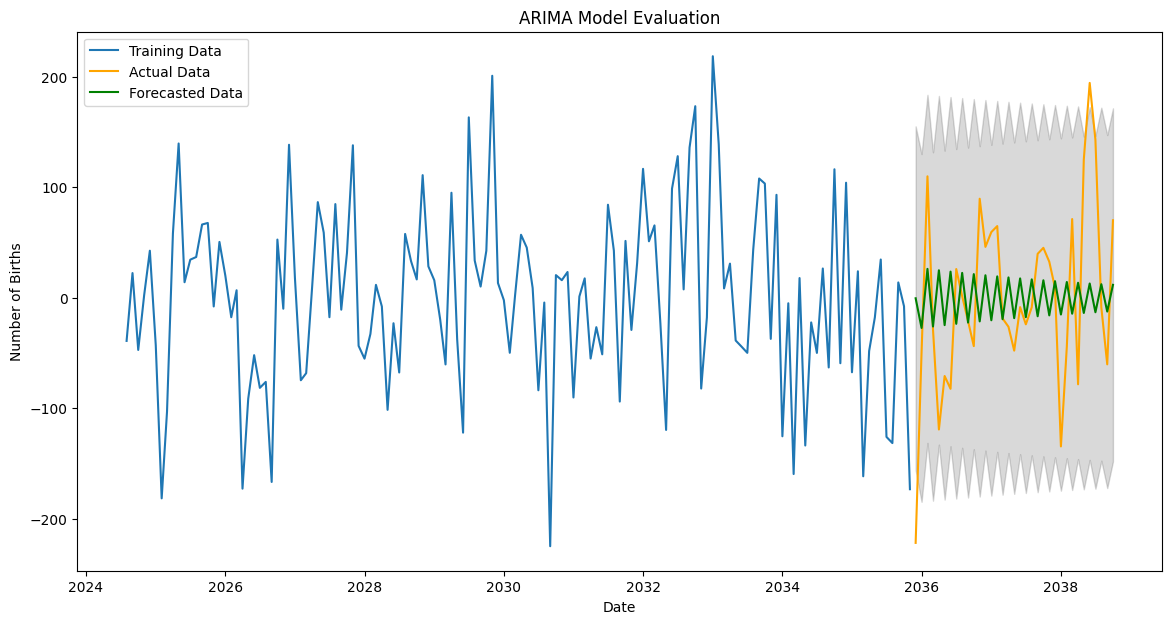

RMSE: 83.86
MAE: 64.5
MAPE: 150.6 %
Model AIC: 1586.19


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model_train = ARIMA(train, order=best_order)
model_train_fit = model_train.fit()
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate Errors
mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test, test_forecast_series)
mape = np.mean(np.abs((test.values - test_forecast_series.values) / test.values)) * 100

# Print the metrics
print('RMSE:', round(rmse, 2))
print('MAE:', round(mae, 2))
print('MAPE:', round(mape, 2), '%')

# AIC for model selection is already available in the model_train_fit object
print('Model AIC:', round(model_train_fit.aic, 2))

### Explain the previous code cell:

**Mean Absolute Percentage Error (MAPE)**

**MAPE** measures the accuracy as a percentage of the actual value. It's often preferred because it provides an easily interpretable, **scale-independent** measure of accuracy.

$$\text{MAPE} = \frac{100}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right|$$

Where $A_t$ is the actual value and $F_t$ is the forecasted value.

A MAPE of 5% is clearly understood as a forecast error that is, on average, 5% of the true value, regardless of whether you are predicting births (small numbers) or national GDP (large numbers).

**Mean Absolute Error (MAE)**

**MAE** is the most intuitive measure of error, as it simply calculates the average magnitude of the errors. Like RMSE, it is **scale-dependent**, but unlike RMSE, it does not involve squaring the errors.

$$\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |A_t - F_t|$$

MAE is **less sensitive to outliers** than RMSE. Because RMSE squares the errors, it disproportionately penalizes large prediction errors. If avoiding high penalties for rare, large errors is important, MAE is a better choice. It is also in the same units as your data (e.g., "number of births").

**Akaike Information Criterion (AIC)**

For **model selection** (choosing the best $p$, $d$, and $q$ for your ARIMA model), the **AIC** is the standard metric. You can't use AIC to compare forecasts to the test set, but you use it to find the *best model* to create those forecasts.

AIC estimates the quality of your model relative to other models. It balances model fit (measured by the log-likelihood) against model complexity (the number of parameters).

$$\text{AIC} = -2 \ln(L) + 2k$$

Where $L$ is the maximized value of the likelihood function for the model, and $k$ is the number of estimated parameters.

AIC automatically implements the principle of **parsimony** (simplicity). When comparing two models, the one with the **lower AIC** is preferred. It guides you to a model that is a good fit to the data without being overly complex (overfitting). You would use this metric when iterating through different $p$ and $q$ values (e.g., ARIMA(1, 0, 0) vs. ARIMA(2, 0, 0)).


## Model Summary

In [14]:
# model summary
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['detrended'], order=(1,0,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              detrended   No. Observations:                  171
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -992.518
Date:                Sun, 02 Nov 2025   AIC                           1993.035
Time:                        16:09:14   BIC                           2005.602
Sample:                    08-01-2024   HQIC                          1998.134
                         - 10-01-2038                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      7.625      0.002      0.999     -14.930      14.958
ar.L1          0.1676      0.454      0.370      0.712      -0.721       1.057
ma.L1          0.0148      0.451      0.033      0.974      -0.870       0.899
sigma2      6440.1432    682.804      9.432      0.000    5101.871    7778.415
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.99   Prob(JB):                         0.92
Heteroskedasticity (H):               1.44   Skew:                            -0.05
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Explain the previous code cell:

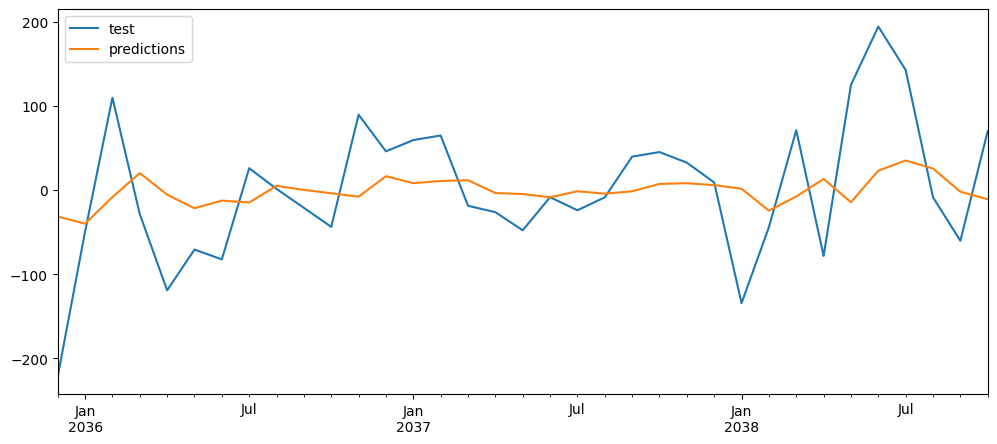

In [15]:
# predictions closeup
predictions = results.predict(start=len(train), end=len(df)-1)
test.plot(legend=True,figsize=(12,5),label='test').autoscale(axis='x',tight=True)
predictions.plot(legend=True, label='predictions');

### Explain the previous code cell:

## The Purpose of $d$

You would use the **$d$** parameter in $\text{ARIMA}(p, d, q)$ when your time series data is **non-stationary** and requires **differencing** to achieve a stationary mean.

The "I" in $\text{ARIMA}$ stands for **Integrated**, and the parameter $d$ specifies the **order of differencing** applied to the series. The fundamental purpose is to remove trends that violate the stationarity assumption needed for the $\text{AR}$ (Autoregressive) and $\text{MA}$ (Moving Average) components of the model.

A time series is **non-stationary** when its statistical properties, such as the mean and variance, change over time. The most common cause is a persistent trend.

* **$d = 0$**: You use $d=0$ when the series is **already stationary**. In this case, the model reduces to an $\text{ARMA}(p, q)$ model.
* **$d = 1$**: You use $d=1$ when the series has a **linear trend** caused by a unit root (stochastic trend), like a Random Walk. This involves calculating the difference between consecutive observations ($Y_t - Y_{t-1}$).
* **$d = 2$**: You use $d=2$ when the first difference is still non-stationary, indicating a **quadratic trend**. Using $d \geq 2$ is rare and should be avoided if possible, as it can lead to **over-differencing**, which obscures the true signal.

**How to Determine the Correct $d$**

To correctly determine $d$, you must use a formal statistical test, typically the **Augmented Dickey-Fuller (ADF) test**.

1.  **Start with $d=0$**: Assume the series is stationary.
2.  **Run the ADF test**: The test's **null hypothesis ($H_0$) is that the series is non-stationary**.
3.  **Iterate Differencing**:
    * If the ADF test fails to reject $H_0$, the series is non-stationary. You then calculate the first difference ($d=1$) and re-run the ADF test on the newly differenced series.
    * You continue increasing $d$ by one and re-testing until the ADF test **rejects $H_0$** (usually with a p-value less than 0.05), confirming that the series is stationary.

You should always choose the **smallest integer $d$** that achieves stationarity.